# Bias-variance tradeoff

Let's define a ground truth $\eta(x)=E[Y|X=x]$ to be a degree-5 polynomial. \
Then, define $P(Y|X=x)=\mathcal{N}(x, \sigma^2)$

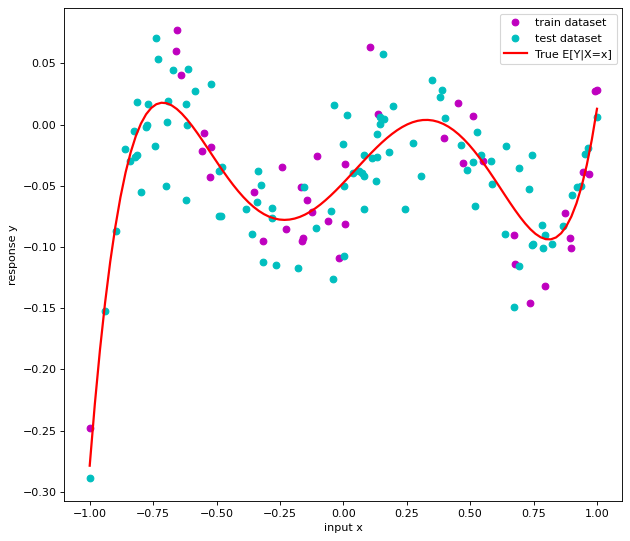

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define \eta = E[Y|X] as a 5-th order polynomial
# (this is the same function we used in demo_polynomial.ipynb)
eta = lambda x: (x-.99)*(x-.4)*(x-.25)*(x+.6)*(x+.8)

# Generate samples from P(X,Y)
def sample_Pxy(n, noise_sigma=0.03):
    
    # Sample inputs x from P(x).
    x = np.random.uniform(-1,1,n) 
    x = np.sort(x)
    x[0]=-1
    x[n-1]=1
        
    # Draw samples from P(Y|X)
    y = eta(x) + noise_sigma*np.random.randn(n)
    
    return x,y

# Generate training data.
n_train = 40 # sample size
x, y = sample_Pxy(n=n_train)

# Generate test data.
n_test = 100
x_, y_ = sample_Pxy(n=n_test)

# Plot the samples and ground truth.
t = np.linspace(-1,1,100)
y0 = eta(t)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x,y,'mo',label='train dataset')
plt.plot(x_,y_,'co',label='test dataset')
plt.plot(t,y0,'r-', linewidth=2, label='True E[Y|X=x]')
plt.legend()
plt.xlabel("input x")
plt.ylabel("response y")
plt.show()


In typical scenarios, we only have one set of samples, which we separate into $S_{\rm test}$ and $S_{\rm train}$

- it is critical that those two sets do not overlap and the sets are chosen randomly to ensure that the test error is independent of the training error, and also the test samples are coming frmo the same distribution as the new samples that will come in the future

However, in order to understand how the test error behaves (theoretically), we consider the expected test error, and call it true error: i.e. ${\cal L}_{\rm true} = {\mathbb E}[{\cal L}_{\rm test}]$ 

- test error is an **unbiased** estimate of the true error
- true error is unobservable (we canot copmute it, given finite samples)
- but we care the most about the true error
- so we use test error as a surrogate or an approximation

In order to compute the true error, we simulate a process where we get many fresh samples, and train new predictor each time with the fresh set of samples. It is important to understand that the resulting predictor $f_{S_{\rm train}}(\cdot)$ is a random function, where the randomness comes from the fresh random training data set $S_{\rm train}$. We will draw many such random functions, plot them, and see how test, train, true errors behave.


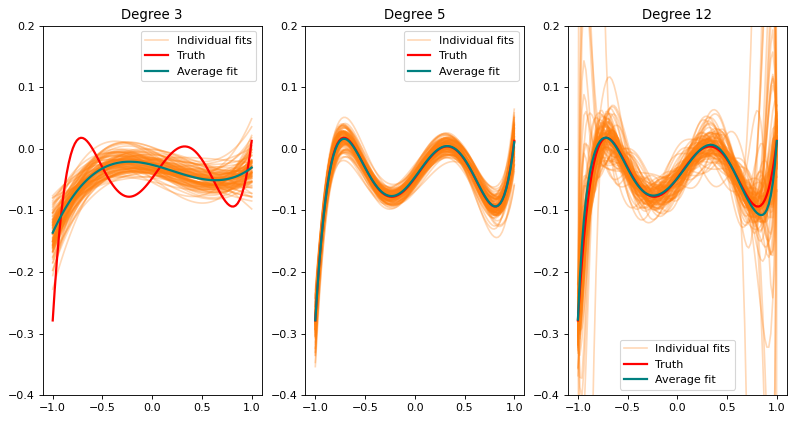

In [2]:
num_runs = 100
yhat_simple = np.zeros((num_runs,len(t)))
yhat_complex = np.zeros((num_runs,len(t)))
yhat_justright = np.zeros((num_runs,len(t)))

def poly_features(x, degree):
    """
    Generates a matrix where each column corresponds to x raised to a power from 0 to 'degree'.
    
    Parameters:
    x (numpy array): The input data.
    degree (int): The maximum degree of the polynomial features.
    
    Returns:
    numpy array: A matrix where the columns are [1, x, x^2, ..., x^degree].
    """
    return np.vstack([x**i for i in range(degree + 1)]).T

run=0
while run < num_runs:
    n = 40 # sample size
    x,y = sample_Pxy(n)

    # degree-3 polynomial linear regression
    p=3
    X = poly_features(x, degree=p)
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
    T_ = poly_features(t, degree=p)
    yhat_simple[int(run)] = np.matmul(T_,w)
    yh = np.matmul(X,w)
    X_ = poly_features(x_, degree=p)
    y_h= np.matmul(X_,w)
    w_ = w
    
    # degree-5 polynomial linear regression
    p=5
    X = poly_features(x, degree=p)
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
    T_ = poly_features(t, degree=p)
    yhat_justright[int(run)] = np.matmul(T_,w)
    yh = np.matmul(X,w)
    X_ = poly_features(x_, degree=p)
    y_h= np.matmul(X_,w)
    w_ = w

    # degree-12 polynomial linear regression
    p=12
    X = poly_features(x, degree=p)
    w = np.array(p+1)
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
    T_ = poly_features(t, degree=p)
    yhat_complex[int(run)] = np.matmul(T_,w)
    yh1 = np.matmul(X,w)
    X_ = poly_features(x_, degree=p)
    y_h1= np.matmul(X_,w)

    run=run+1
    
def build_plot(yhat, title):
    ave_fit = np.zeros(np.size(t))
    for irun in range(1, num_runs):
        plt.plot(t,yhat[int(irun)], color='tab:orange',alpha=0.3)
        ave_fit = ave_fit + yhat[int(irun)]
    plt.plot(t,yhat[0],'tab:orange',alpha=0.3,label='Individual fits')
    plt.plot(t,y0,'r-', linewidth=2, label='Truth')
    plt.plot(t,(1/float(num_runs))*ave_fit, color='teal', linewidth=2,label='Average fit')
    plt.legend()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([-0.4,0.2])

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
build_plot(yhat_simple, 'Degree 3')
plt.subplot(1,3,2)
build_plot(yhat_justright, 'Degree 5')
plt.subplot(1,3,3)
build_plot(yhat_complex, 'Degree 12')
plt.show()


## Takeaways
* True function has degree 5, with additive noise
* Degree 3 fit has very high bias because the teal line, which is the average of the fits, is very different from true red line (because 3 < 5). Each individual fit (orange) varies about the average fit (teal) moderately indicating moderate variance. The overall error (bias$^2$ + variance) of each individual fit is high.
* Degree 12 has very low bias because the teal line is almost equal to the red (because 12 > 5). But each individual fit varies a lot about its average teal line indicating high variance. The overall error (bias$^2$ + variance) of each individual fit is high.
* Degree 5 has very low bias because the teal line is almost equal to the red (because 5 = 5). And each individual fit varies only a little about its average teal line indicating small variance. The overall error (bias$^2$ + variance) of each individual fit is low.